In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, optimizers, losses, metrics, initializers
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input, decode_predictions

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2024-02-27 08:39:20.188279: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 08:39:20.188412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 08:39:20.391330: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dir_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'
IMAGE_SHAPE = (128, 128)

In [3]:
# create prepare_image method
# used to preprocess the image for efficientNet model
def prepare_image(file):
    img = image.load_img(file, target_size=IMAGE_SHAPE)
    img_array = image.img_to_array(img)
    return tf.keras.applications.efficientnet.preprocess_input (img_array)

In [4]:
directories = os.listdir(dir_path) # read the folders

files = [] # save all images for each folder
labels = [] # set for each image the name of it

# read files for each directory
for folder in directories:
    
    fileList = glob.glob(dir_path + '/'+ folder + '/*')
    labels.extend([folder for l in fileList])
    files.extend(fileList)
    
len(files), len(labels)

(1578, 1578)

In [5]:
# create two lists to hold only non-mask images and label for each one
selected_files = []
selected_labels = []

for file, label in zip(files, labels):
    if 'mask' not in file:
        selected_files.append(file)
        selected_labels.append(label)

    
len(selected_files), len(selected_labels)

(780, 780)

In [6]:
# the dictionary holds list of images and for each one has its target/label
images = {
    'image': [], 
    'target': []
}

print('Preparing the image...')

for i, (file, label) in enumerate(zip(selected_files, selected_labels)):
    images['image'].append(prepare_image(file))
    images['target'].append(label)

print('Finished.')

Preparing the image...
Finished.


In [7]:
# convert lists to arrays 
images['image'] = np.array(images['image'])
images['target'] = np.array(images['target'])

# encode the target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

images['target'] = le.fit_transform(images['target'])

classes = le.classes_ # get the classes for each target
print(f'the target classes are: {classes}')

the target classes are: ['benign' 'malignant' 'normal']


In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images['image'], images['target'], test_size=.10)

x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((702, 128, 128, 3), (78, 128, 128, 3), (702,), (78,))

In [9]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

# def VGG16(input_shape=(224, 224, 3), num_classes=3):
#     inputs = Input(shape=input_shape)
    
#     # Block 1
#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
#     # Block 2
#     x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
#     # Block 3
#     x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
#     # Block 4
#     x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
#     # Block 5
#     x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
#     # Classification block
#     x = Flatten()(x)
#     x = Dense(4096, activation='relu')(x)
#     x = Dense(4096, activation='relu')(x)
#     outputs = Dense(num_classes, activation='softmax')(x)
    
#     model = Model(inputs=inputs, outputs=outputs)
#     return model

# # Create VGG16 model
# model = VGG16(input_shape=(224, 224, 3), num_classes=3)

# # Display model summary
# model.summary()


In [10]:
from keras.applications.vgg16 import VGG16
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMAGE_SHAPE, 3),
    classes=3)

# Freeze the base_model
base_model.trainable = False

# append my own layers on the top of the model for Transfer Learning
x = base_model.output

# 1st conv block
x = layers.Conv2D(256, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 2nd conv block
x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 1st FC layer
x = layers.Flatten()(x) 
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# 2nd FC layer
x = layers.Dense(32, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(.2)(x)

x = layers.Dense(3, 'softmax')(x)

incept_model = keras.models.Model(inputs = base_model.input, outputs = x)
# incept_model = keras.models.Model(inputs = base_model.input, outputs = base_model.output)

# compile the model
incept_model.compile(optimizer=optimizers.RMSprop(.001), loss = losses.sparse_categorical_crossentropy, metrics= [metrics.SparseCategoricalAccuracy()])

58889256/58889256 [==============================] - 0s 0us/step


In [11]:
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense

# # Load the pre-trained VGG16 model
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Add new fully connected layers for your classification task
# x = base_model.output
# x = Flatten()(x)
# x = Dense(4096, activation='relu')(x)
# x = Dense(4096, activation='relu')(x)
# outputs = Dense(3, activation='softmax')(x)

# # Create the new model
# incept_model = Model(inputs=base_model.input, outputs=outputs)
# incept_model.compile(optimizer=optimizers.RMSprop(.001), loss = losses.sparse_categorical_crossentropy, metrics= [metrics.SparseCategoricalAccuracy()])

In [12]:
incept_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [13]:
earlyStop = keras.callbacks.EarlyStopping(patience=60) 
best_model = keras.callbacks.ModelCheckpoint(filepath='best_model_128*128.h5', save_best_only=True) 

with tf.device('/gpu:0'):
    history = incept_model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test), callbacks=[earlyStop, best_model]) 

Epoch 1/100


I0000 00:00:1709023196.768003      97 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 [==============================] - 18s 344ms/step - loss: 1.2981 - sparse_categorical_accuracy: 0.4330 - val_loss: 1.0752 - val_sparse_categorical_accuracy: 0.5000
Epoch 2/100


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 1s 56ms/step - loss: 0.8213 - sparse_categorical_accuracy: 0.6738 - val_loss: 0.9252 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/100
22/22 [==============================] - 1s 57ms/step - loss: 0.5803 - sparse_categorical_accuracy: 0.7977 - val_loss: 0.9008 - val_sparse_categorical_accuracy: 0.5641
Epoch 4/100
22/22 [==============================] - 1s 56ms/step - loss: 0.4506 - sparse_categorical_accuracy: 0.8462 - val_loss: 0.8579 - val_sparse_categorical_accuracy: 0.5769
Epoch 5/100
22/22 [==============================] - 1s 68ms/step - loss: 0.3655 - sparse_categorical_accuracy: 0.8846 - val_loss: 0.8265 - val_sparse_categorical_accuracy: 0.6410
Epoch 6/100
22/22 [==============================] - 1s 47ms/step - loss: 0.2661 - sparse_categorical_accuracy: 0.9160 - val_loss: 0.8296 - val_sparse_categorical_accuracy: 0.6410
Epoch 7/100
22/22 [==============================] - 1s 56ms/step - loss: 0.2447 - sparse_categorical_accuracy: 

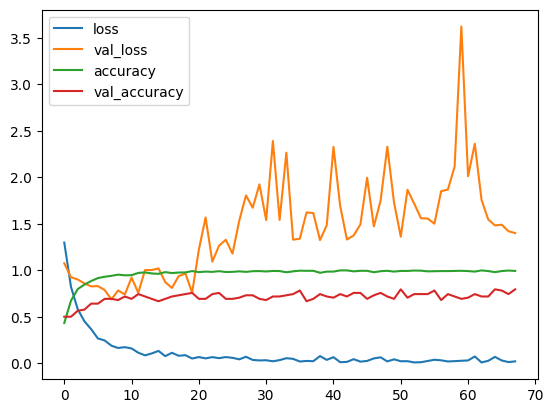

In [14]:
hist = history.history

plt.plot(hist['loss'], label=  'loss')
plt.plot(hist['val_loss'], label = 'val_loss')
plt.plot(hist['sparse_categorical_accuracy'], label='accuracy')
plt.plot(hist['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.legend()

In [15]:
incept_model.evaluate(x=x_test, y = y_test, batch_size=32, verbose=1)

3/3 [==============================] - 0s 37ms/step - loss: 1.4003 - sparse_categorical_accuracy: 0.7949


[1.4002999067306519, 0.7948718070983887]